# Статистика, прикладной поток
## Практическое задание 7

В данном задании вы потренируетесь над практическим применением процедуры проверки статистических гипотез на примере критериев согласия, а так же рассмотрите различные модели линейной регрессии.

**Правила:**

* Дедлайн **15 декабря 23:59**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить на почту ` mipt.stats@yandex.ru`, указав тему письма `"[applied] Фамилия Имя - задание 7"`. Квадратные скобки обязательны. Если письмо дошло, придет ответ от автоответчика.
* Прислать нужно ноутбук и его pdf-версию (без архивов). Названия файлов должны быть такими: `7.N.ipynb` и `7.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 -  8 баллов **O2**
* Задача 2 -  12 баллов **O3**
* Задача 3 -  12 баллов **O3**
* Задача 4 -  15 баллов **O2**
* Задача 5 -  10 баллов **O2**
* Задача 6 -  20 баллов **O3**

In [83]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.sandbox.stats.multicomp import multipletests
from tqdm import tqdm_notebook

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from scipy.linalg import eigvals

%matplotlib inline

## Критерии согласия

При возникновении затруднений посмотрите в ноутбук с лекции.

__________________
### Задача 1.

С помощью критерия хи-квадрат вам нужно проверить, правильно ли `scipy.stats` генерирует случайные величины. 

**1.** Реализуйте критерий для генерации выборки $U\{1, ..., 10\}$, аналогично разобранному на семинаре.

**2.** Проверьте, действительно ли код `sps.poisson(mu=5).rvs(size=1000)` генерирует выборку размера 1000 из пуассоновского распределения с параметром 5. 

*Указания*
1. Не забудьте учесть условия применимости критерия хи-квадрат;
2. Для вычисления плотности воспользуйтесь `sps.poisson(mu=5).pmf`;
3. Для подсчета количества элементов в разбиении на множества воспользуйтесь `np.unique(sample, return_counts=True)`;
4. Не нужно писать сколь-либо универсальный код, который одним нажатием кнопки проверяет гипотезу с учетом всех условий применимости критерия. Расписывайте код поэтапно, на каждый логический этап свой код для *конкретной* реализации выборки. Так вам проще реализовать, а нам проще проверять.

In [44]:
#Для равномерного U[1,..,10]
N = 1000
sample = sps.randint(1, 11).rvs(N)

f_obs = np.unique(sample, return_counts=True)[1]

print(sps.chisquare(f_obs))
print("----Значит не отвергаем")

Power_divergenceResult(statistic=5.779999999999999, pvalue=0.7617189274036045)
----Значит не отвергаем


Проверим двусторонний критерий для $U\{1, ..., 10\}$

In [285]:
#двусторонний критерий
N = 1000
sample = sps.randint(1, 11).rvs(N)

f_obs = np.unique(sample, return_counts=True)[1]

statistic = sps.chisquare(f_obs).statistic

quantil1 = sps.chi2(df=9).ppf(0.05/2)
quantil2 = sps.chi2(df=9).ppf(1 - 0.05/2)

#двусторонний критерий
crit = statistic < quantil1 or statistic > quantil2

print(crit)
print("----Значит не отвергаем")

False
----Значит не отвергаем


In [72]:
#Для пуассона 
N = 1000
sample = sps.poisson(mu=5).rvs(size=N)

#проверяем начиная с какого i склеиваем выборку
i=0
while (sps.poisson(mu=5).pmf(i)*1000 >= 5):
    i += 1

#склеили   
sample[np.where(sample > i)] = i    

f_obs = np.unique(sample, return_counts=True)[1]

#вектор ожидаемых частот
f_exp = [sps.poisson(mu=5).pmf(i)*N for i in range(i)]
f_exp.append((1 - sps.poisson(mu=5).cdf(i-1))*N)


print(sps.chisquare(f_obs=f_obs, f_exp=f_exp))
print("----Не отвергаем")

Power_divergenceResult(statistic=8.206135764305934, pvalue=0.76882118682365)
----Не отвергаем


**Вывод:**

Мы можем видеть, что Критерий хи-квадрат при соблюдении условий применимости действительно применим для определения распределения. Также критерий позволил нам убедится что пуассонвское распределение, и $U\{1, ..., 10\}$ действительно хорошо генерируются библиотекой scipy.  

__________________
### Задача 2.

На лекциях и семинарах были разобраны следующие критерии проверки нормальности:
* Колмогорова
* Жарка-Бера
* Шапиро-Уилка

**1.** Данные критерии являются асимптотическими, и их реальное значение уровня значимости может отличаться от желаемого числа $\alpha=0.05$. На семинарах был разобран метод оценки реального уровня значимости критерия. Посчитайте реальный уровень значимости этих критериев для размеров выборки от 5 до 100.

*Подсказка:*

In [ ]:
max_sample_size = ...
sample_count = ...
is_reject_<критерий> = np.zeros((max_sample_size, sample_count))

for i in tqdm_notebook(range(max_sample_size)):
    for j in range(sample_count):
        sample = ...
        is_reject_<критерий>[i, j] = ...

Ваша реализация:

In [101]:
#считаем значения оценки реального уровня значимости критерия
#
alpha = 0.05

max_sample_size = 100
sample_count = 10000

sample = sps.norm().rvs((sample_count, max_sample_size))

is_reject_kstest = np.zeros((max_sample_size + 1, sample_count))
is_reject_jarque_bera = np.zeros((max_sample_size + 1, sample_count))
is_reject_shapiro_wilk = np.zeros((max_sample_size + 1, sample_count))


for i in tqdm_notebook(range(5, max_sample_size+1)):
    for j in range(sample_count):
        is_reject_kstest[i, j] = (sps.kstest(sample[j, :i+1], cdf=sps.norm().cdf)[1] < alpha)
        is_reject_jarque_bera[i, j] = (sps.jarque_bera(sample[j, :i+1])[1] < alpha)
        is_reject_shapiro_wilk[i, j] = (sps.shapiro(sample[j, :i+1])[1] < alpha)

        
kstest_check = is_reject_kstest[5:].mean(axis=1)
jarque_bera_check = is_reject_jarque_bera[5:].mean(axis=1)
shapiro_wilk_check = is_reject_shapiro_wilk[5:].mean(axis=1)

In [153]:
np.savetxt('kstest_crit.txt', kstest_check, fmt='%f')
np.savetxt('jarque_bera_crit.txt', jarque_bera_check, fmt='%f')
np.savetxt('shapiro_crit.txt', shapiro_wilk_check, fmt='%f')

Поясните, почему вы выбрали такое значение `sample_count`.

Я выбрал равную 10000, т.к. мы знаем что получившиеся с помощью Монте-Карло значение с вероятностью 0.95 будет с точностью до $1/\sqrt{k}$ истинным, поэтому если взять 10000, то оно будет истинным с точностью до 2ого знака. А если мы хотим точность до 3го знака, то sample_count нужно брать 1000000, но это будет слишком долго вычислятся.

Нарисуйте на одном графике зависимость реального уровня значимости от размера выборки для каждого критерия. Пунктиром отметьте уровень 0.05. Не забудьте добавить легенду и подписать оси.

In [277]:
def get_plot(title, kstests, jarque, shapiro, alpha=None):
    if (len(kstests) == 10):
        grid = np.arange(1, 11)
    else:
        grid = np.arange(5, 911)
    plt.figure(figsize=(10, 10))

    plt.title(title, fontsize=14)
    plt.xlabel("размер выборки")

    plt.plot(grid, kstests, label="Колмогоров")
    plt.plot(grid,jarque, label="Жарка-Бера")
    plt.plot(grid,shapiro, label="Шапиро-Уилка")
    if (alpha is not None):
        plt.plot(grid, np.ones(len(grid))*alpha, linestyle='--')

    plt.legend()
    plt.show()

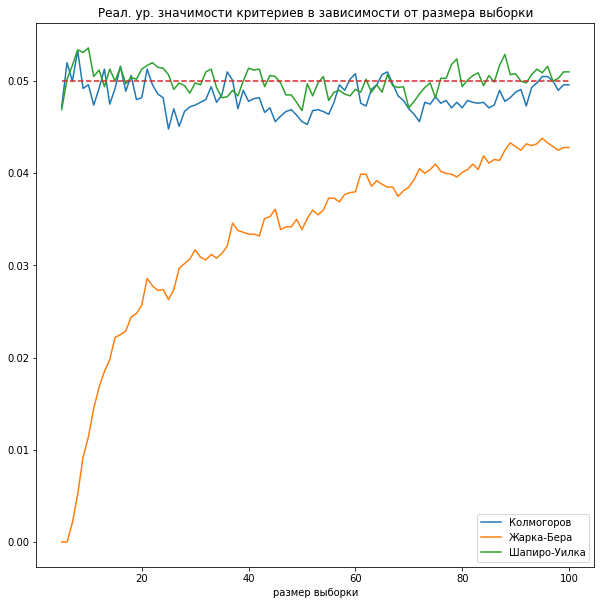

In [154]:
get_plot("Реал. ур. значимости критериев в зависимости от размера выборки",
        kstest_check, jarque_bera_check, shapiro_wilk_check, alpha)    

 Какой можно сделать вывод?

Мы видим, что для критерия Жарка-Бера слишком мало размера выборки, чтобы сойтись к значению асимпт. уровня значимости, то есть видимо он требует большего размера выборки. Поэтому на относительно небольших размерах выборки реальный уровень значимости в критерии Жарка-Бера будет меньше, чем асимптотический, то есть на небольших размерах асимптотический критерий будет отвергать с большей вероятностью, чем мы этого хотим.  А критерии Колмогорова и Шапиро-Уилка уже на маленьких размерах довольно близки к 0.05.

**2.** Аналогичным образом можно вычислять мощность критерия. Вычислите мощности критериев для размеров выборки от 5 до 100, если альтернативная гипотеза заключается в том, что выборка имеет стандартное распределение Коши. Иначе говоря, для критерия $S$ надо приближенно посчитать $\beta_S(\mathsf{P})$, где $\mathsf{P}$ --- стандартное распределение Коши.

Нарисуйте на одном графике зависимость мощности критерия от размера выборки для каждого критерия. Не забудьте добавить легенду и подписать оси.

In [98]:
#считаем оценки мощности мощности
sample = sps.cauchy().rvs((sample_count, max_sample_size))

for i in tqdm_notebook(range(5, max_sample_size+1)):
    for j in range(sample_count):
        is_reject_kstest[i, j] = (sps.kstest(sample[j, :i+1], cdf=sps.norm().cdf)[1] < alpha)
        is_reject_jarque_bera[i, j] = (sps.jarque_bera(sample[j, :i+1])[1] < alpha)
        is_reject_shapiro_wilk[i, j] = (sps.shapiro(sample[j, :i+1])[1] < alpha)

        
kstest_power = is_reject_kstest[5:].mean(axis=1)
jarque_bera_power = is_reject_jarque_bera[5:].mean(axis=1)
shapiro_wilk_power = is_reject_shapiro_wilk[5:].mean(axis=1)

In [155]:
#загружаю данные, предвар. подсчитанные в вспомогательном ноутбуке
kstest_power = np.loadtxt('kstest_power.txt')
jarque_bera_power = np.loadtxt('jarque_bera_power.txt')
shapiro_wilk_power = np.loadtxt('shapiro_power.txt')

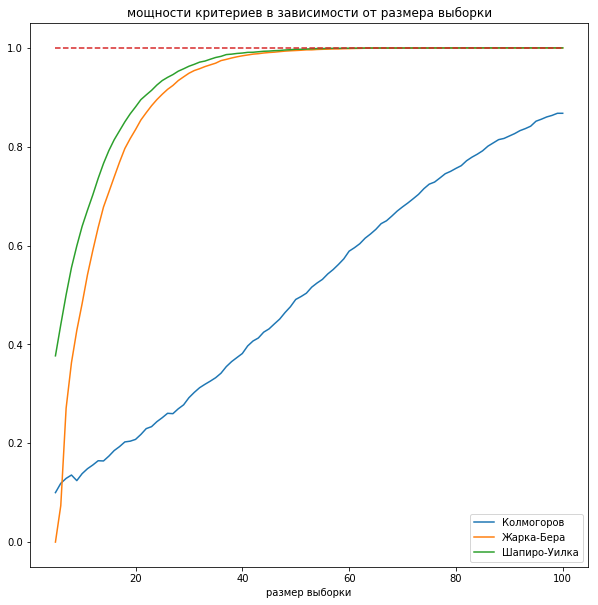

In [157]:
get_plot("мощности критериев в зависимости от размера выборки",
        kstest_power, jarque_bera_power, shapiro_wilk_power, 1)

Сделайте вывод. Какой критерий является наиболее мощным при данной альтернативе?

Мы видим, что мощности всех критериев сходятся к единице с ростом размера выборки. Можно отметить, что критерий Шапиро-Уилка самый мощный из этих трех на любом размере выборке, а Колмогоров наименее мощный, к тому же имеет маленькую скорость сходимости к единице, не успевает как следует сойтись на таких размерах выборки. Значит на каких-то не слишком больших размерах выборки будет плохо отвергать гипотезу $H_0$.

**3.** Распределение Стьюдента является в некотором смысле обобщением нормального распределения (при бесконечном количестве степеней свободы) и распределения Коши (при одной степени свободы). 
Посчитайте приближенно мощности критериев для выборки размера 50 если альтернатива заключается в том, что выборка имеет распределение Стьюдента. Поскольку мощность критерия является функцией от распределения из альтернативной гипотезы, вам нужно посчитать функцию. Посчитайте ее для целых значений степени свободы от 1 до 10.

Нарисуйте на одном графике зависимость мощности критерия от количества степеней свободы для каждого критерия. Не забудьте добавить легенду и подписать оси.

In [280]:
sample = sps.t(df=np.arange(1, 11).reshape(-1, 1, 1)).rvs(size=(10, 1000, 50))

is_reject_kstest = np.zeros((10, 1000))
is_reject_jarque_bera = np.zeros((10, 1000))
is_reject_shapiro_wilk = np.zeros((10, 1000))

for i in tqdm_notebook(range(10)):
    for j in range(1000):
        is_reject_kstest[i, j] = (sps.kstest(sample[i, j], cdf=sps.norm().cdf)[1] < alpha)
        is_reject_jarque_bera[i, j] = (sps.jarque_bera(sample[i, j])[1] < alpha)
        is_reject_shapiro_wilk[i, j] = (sps.shapiro(sample[i, j])[1] < alpha)

kstest_power = is_reject_kstest.mean(axis=1)
jarque_bera_power = is_reject_jarque_bera.mean(axis=1)
shapiro_wilk_power = is_reject_shapiro_wilk.mean(axis=1)       

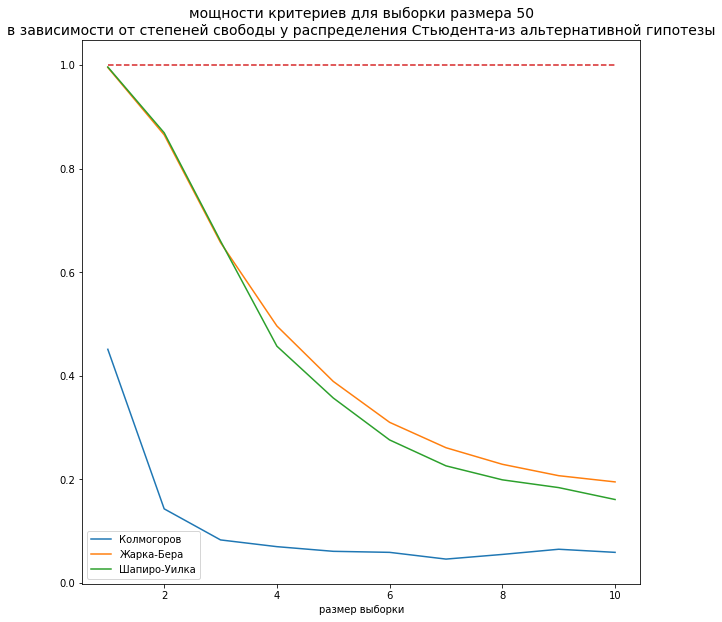

In [281]:
get_plot("мощности критериев для выборки размера 50\n" + \
         "в зависимости от степеней свободы у распределения Стьюдента" + \
         "-из альтернативной гипотезы",
        kstest_power, jarque_bera_power, shapiro_wilk_power, 1)

Сделайте вывод относительно мощности критерия при разных распределениях из альтернативы.

Здесь мы видим, что мощности всех критериев стремятся к нулю. Причем мощность критерия Колмогорова устремляется к нулю гораздо быстрее остальных, и уже на малых значениях степени свободы близка к нулю, то есть почти не будет отвергать. 

**4.** Аналогичным образом посчитайте мощности критериев, если альтернативная гипотеза заключается в том, что выборка имеет экспоненциальное распределение.

In [167]:
sample = sps.expon(scale=(1/np.arange(1, 11)).reshape(-1, 1, 1)).rvs(size=(10, 1000, 50))

is_reject_kstest = np.zeros((10, 1000))
is_reject_jarque_bera = np.zeros((10, 1000))
is_reject_shapiro_wilk = np.zeros((10, 1000))

for i in tqdm_notebook(range(10)):
    for j in range(1000):
        is_reject_kstest[i, j] = (sps.kstest(sample[i, j], cdf=sps.norm().cdf)[1] < alpha)
        is_reject_jarque_bera[i, j] = (sps.jarque_bera(sample[i, j])[1] < alpha)
        is_reject_shapiro_wilk[i, j] = (sps.shapiro(sample[i, j])[1] < alpha)

kstest_power = is_reject_kstest.mean(axis=1)
jarque_bera_power = is_reject_jarque_bera.mean(axis=1)
shapiro_wilk_power = is_reject_shapiro_wilk.mean(axis=1) 

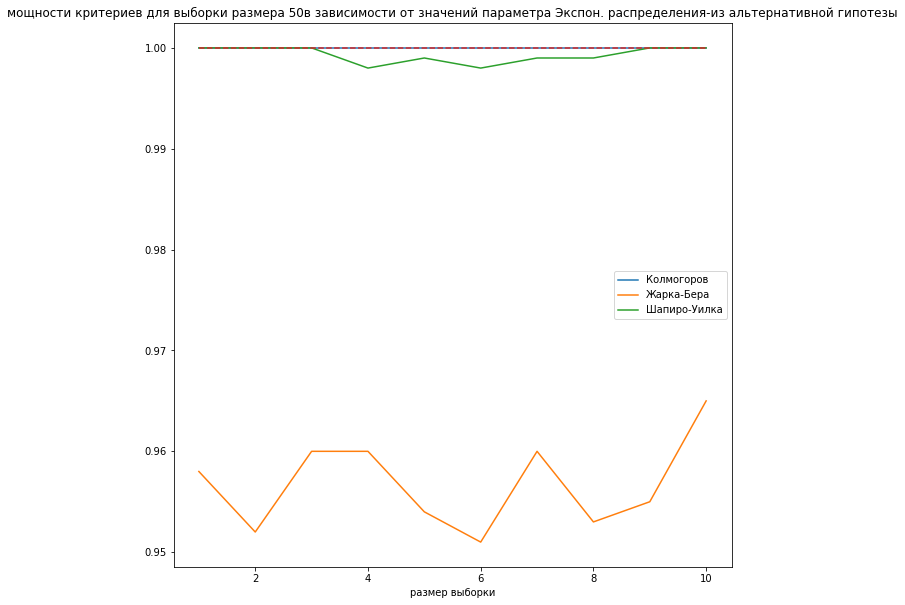

In [168]:
get_plot("мощности критериев для выборки размера 50" + \
         "в зависимости от значений параметра Экспон. распределения" + \
         "-из альтернативной гипотезы",
        kstest_power, jarque_bera_power, shapiro_wilk_power, 1)

Сделайте вывод:

Здесь мы видим, что Критерии имеет очень высокую мощность, Колмогоров, вообще почти неотличим от единицы, то есть почти наверняка отвергнет. А Жарка-Уилка чуть меньше остальных, но все равно очень близок к единице.

**Общий вывод по задаче:**
Мы пронаблюдали за достоинствами и недостатками некоторых критериев проверки нормальности. Мы увидели, что критерий Колмогорова имеет низкую мощность, которая медленно сходится к единице с ростом выборки. А также увидели, что если альтернативное распределение "похоже" на нормальное, то оно имеет совсем низкую мощность, и практически наверняка ничего не отвергает. Но зато если альтернатива непохожа на нормальное, то отвергнет практически точно гипотезу $H_0$ в случае справедливости альтернативы. 
А критерий Шапира-Уилка гораздо лучше - у него и мощность выше, и более устойчив, и реальный уровень значимости - быстро сходится к асимптотическому. Вообщем хороший со всех сторон.
А Жарка-Уилка видимо нельзя применять к таким небольшим выборкам, так как он очень долго сходится к асимпт. уровню значимости, и из-за этого вряд ли применим здесь. 

__________________
### Задача 3.


Cкачайте данные <a href="http://archive.ics.uci.edu/ml/datasets/wine">`wine dataset`</a>, взяв все колонки, кроме `Class`.

In [178]:
data = pd.read_csv("wine.data")
data = data.iloc[:, 1:]
data.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Для каждого параметра нарисуте Q-Q plot. Для наглядности и экономии места рисуйте графики в несколько столбцов, используя `plt.subplot`.

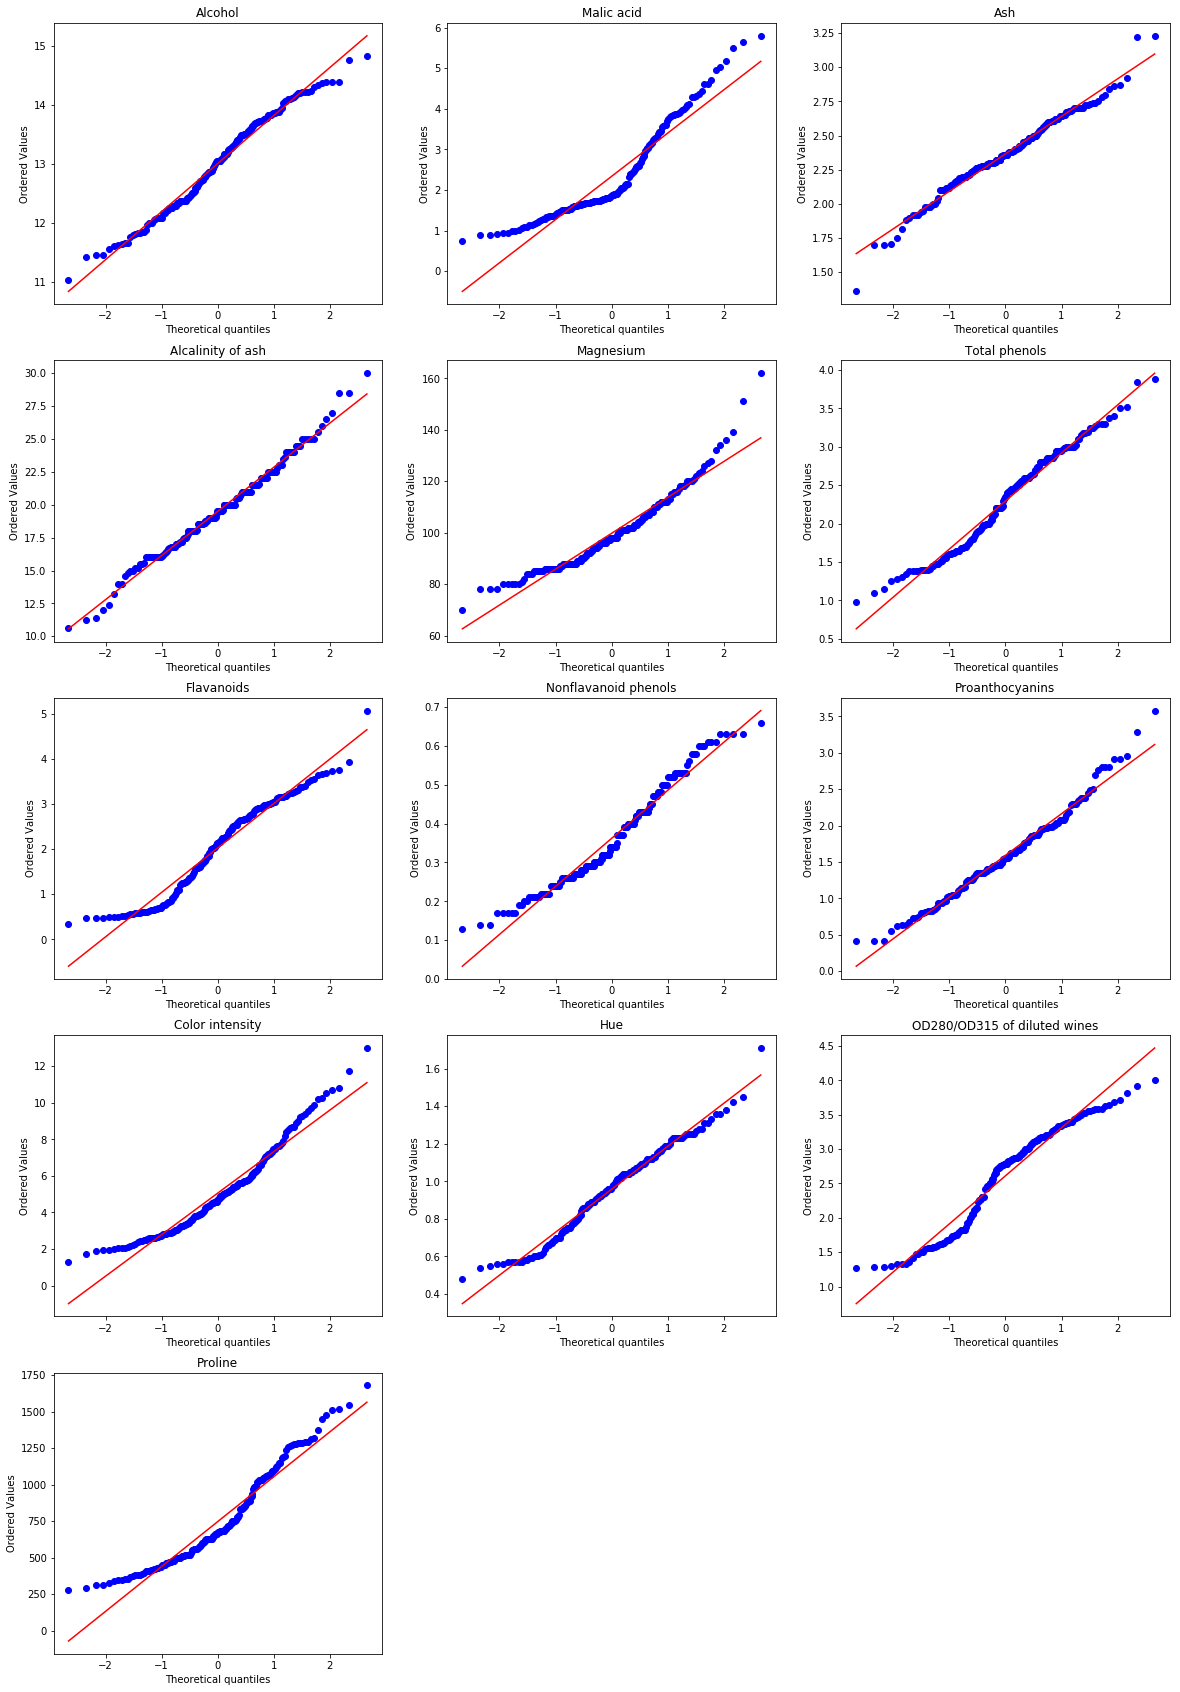

In [192]:

plt.figure(figsize=(20, 30))

for ind, column in enumerate(data.columns):
    sample = data[column]
    plt.subplot(5, 3, ind+1)

    sps.probplot(sample, plot=plt)
    plt.title(column)

plt.show()

Для каких параметров можно говорить об их нормальности и почему?

**Ответ:** Мы можем говорить о нормальности Ash, Alcanity of Ash, Proanthocyanis, Hue, Magnezium так как, как показывают графики, на которых ихображены точки $(x_i, F^{-1}_{0, 1}(x_i))$ выборок, эти точки примерно лежат на одной прямой, что и требуется в методе QQ Plot. 

Проверьте нормальность каждого параметра статистическими критериями. Прежде чем выполнить следующую часть задачи, ответьте на вопросы. Помочь в этом может теоретическое домашнее задание 11, разбор которого был выложен в чате.

Для каждого параметра используйте несколько критериев проверки нормальности. Какие критерии вы будете использовать?

**Ответ:** Мы рассмотрели в прошлой задаче три критерия нормальности, я буду использовать Жарка-Бера и Шапиро-Уилка. (Для Колмогорова нужно проверять какое-то конкретное распределение, а не семейство)

Результаты критериев нужно обработать с помощью *одной* процедуры множественной проверки гипотез для всех параметров и всех критериев сразу. Почему так нужно делать?

**Ответ:** Потому что если мы будем проверять критерии проверки гипотезы отдельно, то ошибка 1го рода может увеличиться в несколько раз(по количеству критериев). Мы знаем, что если хотя бы один критерий отвергается, то значит, что мы должны отвергнуть гипотезу совсем. Поэтому логично контролировать такую штуку как FWER - то есть вероятность того, что мы при проверке критериев получим хотя бы одну ошибку 1ого рода. И множественная проверка гипотез как раз это и позволяет контролировать. 

Какой метод для контроля FWER стоит применить и почему?

**Ответ:** можем применить метод Холма или метод Бонферрони для контроля FWER, но Бонферрони обладает слишком низкой мощностью, а мы знаем из лекции, что если мы не знаем зависимости между статистиками критериев, то нельзя построить процедуру мощнее метода Холма. Поэтому берем его.

Как понять из результата процедуры множественной проверки гипотез, нормальность каких параметров следует отклонить?

**Ответ:** Если у какого-то параметра хотя бы один критерий проверки отвергается, то есть p_value этого критерия будет больше $\alpha$,то гипотезу нормальности этого параметра отклоняем.

Если нормальность не отклоняется, что можно сказать про выборку (ответ в презентации с лекции)? 

**Ответ:** Если не отколняется нормальность, то значит, что выборка согласуется с гипотеой о нормальности. Но вообще, вполне возможно, что это ничего не значит, т.к. это может означать что наши методы недостаточно мощные для данного случая, и следует выбрать более мощные критерии проверки гипотезы.

Реализуйте данную схему. Предварительно соберите p-value всех критериев в таблицу. 

Функция `multipletests` принимает только одномерные массивы, поэтому для полученной `numpy`-таблицы нужно воспользоваться методом `ravel`. Результат нужно собрать обратно в таблицу с помощью метода `reshape`, которому нужно передать размерности таблицы. Для наглядности сделайте таблицу с помощью `pandas.DataFrame`. В качестве названий строк используйте названия переменных, а названий столбцов --- используемые критерии.

In [202]:
rowJB = list()
rowSW = list()
array = list()
for column in data.columns:
    rowJB.append(sps.jarque_bera(data[column])[1])
    rowSW.append(sps.shapiro(data[column])[1])
    array.append((sps.jarque_bera(data[column])[1],
                sps.shapiro(data[column])[1]))

p_values_table = pd.DataFrame(array, 
                              index=data.columns,
                             columns=['Jarque-Bera p_value',
                                    'Shapiro p_value'])

p_values_table

,Jarque-Bera p_value,Shapiro p_value
Alcohol,6.106775e-02,2.005172e-02
Malic acid,1.115426e-07,2.945930e-10
Ash,8.485917e-03,3.868526e-02
Alcalinity of ash,2.509338e-01,2.638694e-01
Magnesium,6.883383e-15,6.345416e-07
Total phenols,6.312188e-02,4.395752e-03
Flavanoids,5.273120e-02,1.679064e-05
Nonflavanoid phenols,1.071359e-02,1.055266e-04
Proanthocyanins,7.840977e-03,1.445338e-02
Color intensity,1.092262e-05,9.229477e-07


In [204]:
p_values = p_values_table.get_values().ravel()
tests = multipletests(p_values, method='holm')[0]

rejects = pd.DataFrame(tests.reshape(-1, 2), 
                       index=data.columns,
                      columns=['Jarque-Bera rejects',
                            'Shapiro rejects'])
rejects

,Jarque-Bera rejects,Shapiro rejects
Alcohol,False,False
Malic acid,True,True
Ash,False,False
Alcalinity of ash,False,False
Magnesium,True,True
Total phenols,False,False
Flavanoids,False,True
Nonflavanoid phenols,False,True
Proanthocyanins,False,False
Color intensity,True,True


Для каких параметров нормальность не отвергается?

**Ответ:** Не отвергается для Alcohol, Ash, Alcalinity of ash, Total phenols, Proanthocyanins, Hue.

**Вывод:**
Наши предположения, основанные на наблюдениях в QQ Plot хорошо соотносятся с проверками статистическими критериями, но все равно есть различия - некоторые параметры я отнес в "нормальные" в QQ plot, хотя они были отвергнуты МПГ, и наоборот. В целом возможно, что те параметры, которые подвердились как в QQ Plot, так и в МПГ действительно имеют нормальное распределение, то есть выборка согласуется с гипотезой о нормальности.

## Линейная регрессия

__________________
### Задача 4.

По шаблону напишите класс, реализующий гауссовскую линейную регрессию. Интерфейс этого класса в некоторой степени соответствует классу <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression">`LinearRegression`</a> из библиотеки `sklearn`.

In [ ]:
class LinearRegression:
    def __init__(self):
        super()
        
    def fit(self, X, Y, alpha=0.05):
        ''' Обучение модели. Предполагается модель Y = X * theta + epsilon, 
            где X --- регрессор (матрица размера n x d), 
            Y --- отклик (матрица размера n x 1),
            а epsilon имеет нормальное распределение 
            с параметрами (0, sigma^2 * I_n).
            alpha --- уровень значимости критерия 
            (1-alpha --- ур. доверия для доверительного интервала).
        '''
        
        self.n, self.d = X.shape
        
        self.theta = <МНК-оценка>
        self.sigma_sq = <несмещенная оценка для sigma^2>
        self.conf_int = <доверительные интервалы для 
                        коэффициентов (матрица размера d x 2)>
        self.t_stats = <статистики критериев о незначимости 
                        коэффициентов (вектор размера d)>
        self.pvalue = <p-value критериев о незначимости 
                        коэффициентов (вектор размера d)>
        
        return self
    
    def summary(self):
        print('Linear regression on %d features and %d examples' \
              % (self.d, self.n))
        print('Sigma: %.6f' % self.sigma_sq)
        
        # Далее напечатайте таблицу, 
        # в которой для каждого коэффициента (по строкам)
        # будут следующие столбцы:
        # оценка, границы дов. интервала (два столбца), 
        # статистика критерия, p-value
        <...>
        
    def predict(self, X):
        ''' Возвращает предсказание отклика на новых объектах X. '''
        
        Y_pred = <...>
        return Y_pred

Загрузите данные о потреблении мороженного в зависимости от температуры воздуха и цены (файл `ice_cream.txt`).
Примените реализованный выше класс линейной регрессии к этим данным предполагая, что модель имеет вид $ic = \theta_1 + \theta_2\ t$, где $t$ --- температура воздуха (столбец `temp`), $ic$ --- постребление мороженного в литрах на человека (столбец `IC`).
Значения температуры предварительно переведите из Фаренгейта в Цельсий [(Фаренгейт — 32) / 1,8 = Цельсий].

К обученной модели примените фунцию `summary` и постройте график регрессии, то есть график прямой $ic = \widehat{\theta}_1 + \widehat{\theta}_2\ t$, где $\widehat{\theta}_1, \widehat{\theta}_2$ --- МНК-оценки коэффициентов.
На график нанесите точки выборки.

In [ ]:
<...>

Теперь учтите влияние года (столбец `Year`) для двух случаев:
* модель $ic = \theta_1 + \theta_2\ t + \theta_3 y_1 + \theta_4 y_2$, где $y_1 = I\{1\ год\}, y_2 = I\{2\ год\}$. Поясните, почему нельзя рассмативать одну переменную $y$ --- номер года.
* для каждого года рассматривается своя линейная зависимость $ic = \theta_1 + \theta_2\ t$.

В каждом случае нарисуйте графики. Отличаются ли полученные результаты? От чего это зависит? Как зависит потребление мороженного от года? 

In [ ]:
<...>

Наконец, обучите модель на предсказание потребления мороженного в зависимости от всех переменных.
Не забудьте, что для года нужно ввести две переменных.
Для полученной модели выведите `summary`.

In [ ]:
<...>

Но это еще не все.
Постройте теперь линейную регрессию для модели $ic = \theta_1 + \theta_2\ t + \theta_3\ t^2 + \theta_4\ t^3$.
Выведите для нее summary и постройте график предсказания, то есть график кривой $ic = \widehat{\theta}_1 + \widehat{\theta}_2\ t + \widehat{\theta}_3\ t^2 + \widehat{\theta}_4\ t^3$. Хорошие ли получаются результаты?

In [ ]:
<...>

Чтобы понять, почему так происходит, выведите значения матрицы $(X^T X)^{-1}$ и посчитайте для нее индекс обусловленности $\sqrt{\left.\lambda_{max}\right/\lambda_{min}}$, где $\lambda_{max}, \lambda_{min}$ --- максимальный и минимальный собственные значения матрицы $X^T X$. Собственные значения можно посчитать функцией <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eigvals.html">`scipy.linalg.eigvals`</a>.

Прокомментируйте полученные результаты. Помочь в этом может следующая <a href="https://ru.wikipedia.org/wiki/%D0%A7%D0%B8%D1%81%D0%BB%D0%BE_%D0%BE%D0%B1%D1%83%D1%81%D0%BB%D0%BE%D0%B2%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8">статья</a>.

In [ ]:
<...>

__________________
### Задача 5.

В данной задаче нужно реализовать функцию отбора признаков для линейной регрессии. Более подробно, пусть у объектов есть признаки $x_1, ... , x_k$. Нужно определить, какое подмножество признаков $x_{j_1}, ... , x_{j_s}$ нужно использовать, чтобы качество полученной модели $y = \theta_0 + \theta_{j_1} x_{j_1} + ... + \theta_{j_s} x_{j_s}$ было максимальным.

Один из методов, решающих эту задачу описан ниже.

Сначала имеющаяся выборка случайно разделяется на обучающую выборку и тестовую (train и test). Для некоторого подмножества признаков на обучающей выборке обучается модель, после чего вычисляется её качество на тестовой выборке. Операция повторяется для всех подмножеств признаков. Лучшей считается модель с наилучшим качеством на тестовой выборке.

Иначе говоря, сначала выборка $X$ разделяется по объектам на $X_{train} \sqcup X_{test} = X$ . Далее, в цикле по всем подмножествам индексов признаков $(j_1, .. j_s)$ на обучающей выборке $X_{train}$ обучается модель $y = \theta_{j_1} x_{j_1} + ... + \theta_{j_s} x_{j_s}$, после чего считается её качество на $X_{test}$.

В данной задаче под метрикой качества понимается средний квадрат ошибки (mean squared error)

$$MSE = \frac{1}{n} \sum\limits_{x \in X_{test}} \left(\widehat{y}(x) - Y(x)\right)^2,$$
где $x$ -  объект, $Y(x)$ - значение целевой переменной (отклика) на объекте $x$, а $\widehat{y}(x)$ - оценка отклика на объекте $x$.

Заметим, что полный перебор подмножеств признаков требует большого времени. Кратко проблема отбора признаков состоит в том, что могут быть два признака, добавление каждого из которых ухудшает (не улучшает) качество, но добавление двух признаков сразу увеличивает качество.

Для выполнения задания воспользуйтесь следующими функциями:
* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression">`sklearn.linear_model.LinearRegression`</a>
--- реализация линейной регрессии. В данной реализации свободный параметр $\theta_1$ по умолчанию автоматически включается в модель. Отключить это можно с помощью `fit_intercept=False`, но это не нужно. *В данной задаче требуется, чтобы вы воспользовались готовой реализацией линейной регрессии, а не своей. Ведь на практике важно уметь применять готовые реализации, а не писать их самостоятельно.*

* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">`sklearn.model_selection.train_test_split`</a>
--- функция разбиения данных на train и test. Установите параметр `test_size=0.3` и `random_state=17`.

* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html">`sklearn.metrics.mean_squared_error`</a>
--- реализация MSE.

Для перебора реализуйте следующий класс. Данный класс частично реализует интерфейс, похожий на интерфейс <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">`sklearn.model_selection.GridSearchCV`</a>

In [ ]:
class BestFeaturesSelection:
    def __init__(self, estimator, scoring, parameters=dict(), 
                 test_size=0.3, random_state=17, minimize=True):
        """
        Отбор наилучших признаков
        estimator: конструктор класса, например, LinearRegression
        paramters: параметры, передаваемые конструктору estimator, 
                    например dict(fit_intercept=False)
        scoring: функция риска, например, mean_squared_error
        minimize: минимизировать ли функционал качества 
                    (иначе - максимизировать)
        """
        
        self.estimator = estimator
        self.parameters = parameters
        self.scoring = scoring
        self.test_size = test_size
        self.random_state = random_state
        self.minimize=minimize
        
    def fit(self, X, y):
        """
        Подбор лучшего подмножества признаков 
        и обучение модели на нём
        """
        
        # разделение выборки на test и train. Не перепутайте порядок !
        X_train, X_test, y_train, y_test = <...>
        
        self.results_ = []  # список пар (вектор использованных признаков, 
                            # значение функции потерь)
        features_count = X.shape[1]
        
        for bitmask in range(1, 2 ** features_count):
            subset = [i == "1" for i in np.binary_repr(bitmask, 
                                                       width=features_count)]
            # binary_repr возвращает строку длины width с двоичным 
            # представлением числа и ведущими нулями
            
            score = <...>  # вычисление качества модели
    
            self.results_.append((subset, score))
        
        self.results_.sort(key = lambda pair: pair[1],
                           reverse=not self.minimize) 
        # сортируем по второму элементу в нужном порядке
        
        self._best_subset = self.results_[0][0]
        self._best_estimator = self.estimator(**self.parameters)
        self._best_estimator.fit(X_train[:, self._best_subset], y_train)
        
        return self._best_estimator
        
    def predict(self, X):
        """
        Предсказание модели, 
        обученной на наилучшем подмножестве признаков.
        """
        
        return self._best_estimator.predict(X[:, self._best_subset]);

Примените реализованный отбор признаков к датасетам
* <a href="http://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics">Yacht Hydrodynamics</a> --- для парусных яхт нужно оценить остаточное сопротивление на единицу массы смещения (последний столбец) в зависимости от различных характеристик яхты.

* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston">Boston Housing Prices</a> --- цены на дома в Бостоне в зависимости от ряда особенностей.

Посмотрите на графики зависимости целевой переменной от каждого признака. Какие бы признаки вы стали использовать? Совпадает ли ваш выбор с результатом алгоритма, описанного выше? 

In [ ]:
# место для вашего решения

__________________
### Задача 6.

Рассмотрим модель $Y = X \theta + \varepsilon$, где $X \in \mathbb{R}^{n \times k}$ --- регрессор, $Y \in \mathbb{R}^{n \times 1}$ --- отклик, а $\varepsilon \sim \mathcal{N}(0, \beta^{-1}  I_n)$. При классической постановке задачи линейной регрессии оценка параметра $\theta$ находится минимизацией остаточной суммы квадратов ($RSS = \|Y - X\theta\|^2$) и равна $ \overset{\wedge}{\theta} = (X^{т}X)^{-1}X^{т}Y$. Часто также рассматривают регуляризацию, эквивалентную баесовской постановке задачи. Если в качестве априорного на $\theta$ взять $\mathcal{N}(0, \alpha^{-1}I_k)$, то оценкой параметра является математическое ожидание апостериорного распределения (которое в данном случае она совпадает с модой) $\overset{\wedge}{\theta} = \left(X^{т}X + \frac{\alpha}{\beta}I_k\right)^{-1}X^{т}Y$. Такая постановка задачи соответствует случаю Ridge-регрессии. Если же $\theta$ имеет в качестве априорного распределение Лапласа, то оценкой параметра является мода апостерионого распределения. Данная постановка задачи соответствует случаю Лассо регрессии и не решается аналитически.

При выполнении задания воспользуйтесь готовыми реализациями:
* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">`sklearn.linear_model.LinearRegression` </a>

* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html">`sklearn.linear_model.RidgeRegression`</a>

* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html">`sklearn.linear_model.LassoRegression`</a>

В обоих случаях свободный параметр автоматически включается в модель, отключить это можно с помощью `fit_intercept=False`. В случае Ridge и Lasso регрессии параметр `alpha` отвечает за регуляризацию, по умолчанию он принимает значение 1.0. В обозначениях выше для Ridge-регрессии `alpha` $= \frac{\alpha}{\beta}$.


Для выполнения задания скачайте данные <a href="https://dasl.datadescription.com/datafile/cost-of-living-2018/?_sfm_cases=539+541">`cost of living 2018` </a>, в которых используйте следующие столбцы:
* `Cost of Living Index` --- является относительным показателем цен на потребительские товары, включая продукты, рестораны, транспорт и коммунальные услуги. Cost of Living Index не включает расходы на проживание, такие как аренда или ипотека. Если город имеет индекс стоимости жизни 120, это означает, что Numbeo оценивает его на 20% дороже, чем Нью-Йорк.

* `Rent Index` --- это оценка цен на аренду квартир в городе по сравнению с Нью-Йорком. Если индекс арендной платы равен 80, Numbeo оценивает, что цена аренды в этом городе в среднем на 20% меньше, чем цена в Нью-Йорке.

* `Cost of Living Plus Rent Index` --- это оценка цен на потребительские товары, включая арендную плату, по сравнению с Нью-Йорком.

* `Restaurant Price Index` --- сравнение цен на блюда и напитки в ресторанах и барах по сравнению с Нью-Йорк.

* `Local Purchasing Power Index` --- показывает относительную покупательную способность при покупке товаров и услуг в данном городе за среднюю заработную плату в этом городе. Если внутренняя покупательная способность составляет 40, это означает, что жители этого города со средней зарплатой могут позволить себе покупать в среднем на 60% меньше товаров и услуг, чем жители Нью-Йорка со средней зарплатой по Нью-Йорку.

* `Groceries Index` --- это оценка цен на продукты в городе по сравнению с Нью-Йорком. Для расчета этого раздела Number использует веса товаров в разделе "Рынки" для каждого города.

Задача заключается в построении предсказания `Groceries Index` по известным значениям остальных параметров.

Для начала исследуйте зависимость значений коэффициентов от параметра регуляризации для Ridge и Lasso регрессии. Для этого в обоих случаях постройте график значений каждого из коэффициентов в зависимости от параметра регуляризации `alpha` из реализации `sklearn`. Для Ridge-регрессии в качестве значений параметра рекомендуется брать отрезок от 0 до примерно 0.3-0.5. Для Lasso от 0 до 600-800.

In [228]:
costs = pd.read_csv("cost-of-living-2018.txt", sep='\t')
costs = costs.loc[:,["Cost of Living Index","Rent Index",
                   "Cost of Living Plus Rent Index",
                   "Restaurant Price Index",
                   "Local Purchasing Power Index",
                   "Groceries Index"]]
costs = costs.dropna()
costs.head()

,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Restaurant Price Index,Local Purchasing Power Index,Groceries Index
0,145.43,110.87,128.76,158.75,112.26,143.47
1,141.25,66.14,105.03,135.76,142.70,149.86
2,134.83,71.70,104.38,129.74,130.96,138.98
3,130.68,49.68,91.61,127.22,139.01,127.54
4,128.03,43.57,87.30,119.48,112.71,132.70


In [244]:
ridge_grid = np.linspace(0, 0.5, 1000)
lasso_grid = np.linspace(0, 600, 1000)

lasso_coefs = list()
ridge_coefs = list()

for r, l in zip(ridge_grid, lasso_grid):
    ridge_regressor = Ridge(r)
    lasso_regressor = Lasso(l)
    ridge_regressor.fit(costs.iloc[:, :-1], costs["Groceries Index"])
    lasso_regressor.fit(costs.iloc[:, :-1], costs["Groceries Index"])
    
    ridge_coefs.append(ridge_regressor.coef_)
    lasso_coefs.append(lasso_regressor.coef_)
    

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # This is added back by InteractiveShellApp.init_path()
/home/ilya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/ilya/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


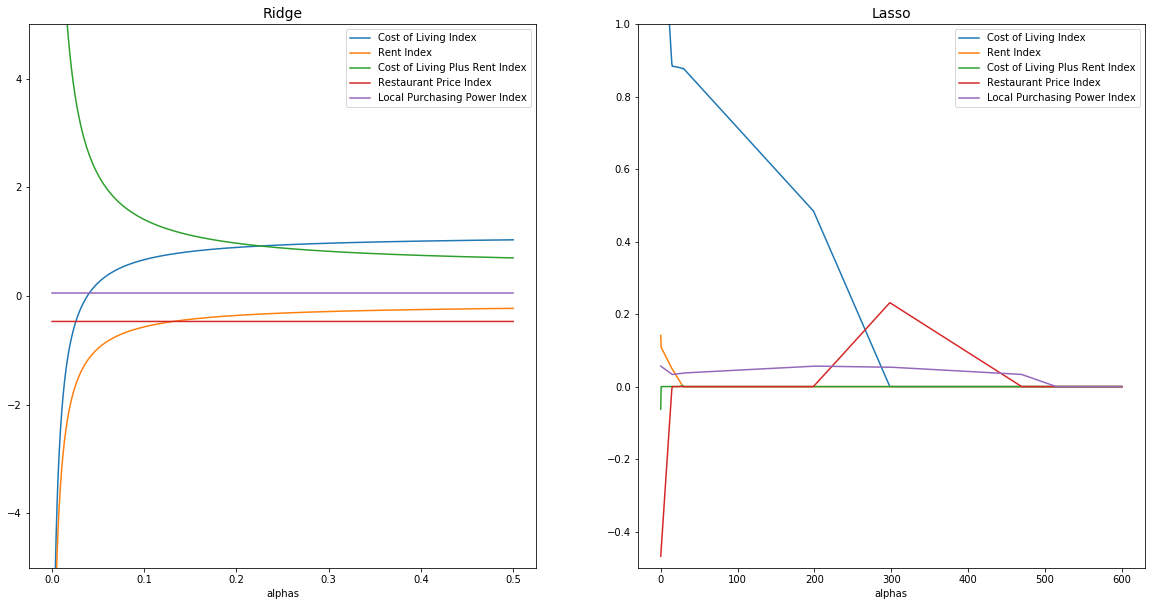

In [251]:
def get_plot(grid, coefs,i, title, ylim):
    plt.subplot(1, 2, i)
    
    plt.title(title, fontsize=14)
    
    plt.ylim(ylim)
    plt.xlabel("alphas")
    for i in range(coefs.shape[1]):
        plt.plot(grid, coefs[:, i], label=costs.columns[i])
    plt.legend()
    
    
plt.figure(figsize=(20,10))        
    
get_plot(ridge_grid, ridge_coefs, 1,
        "Ridge", (-5, 5))
get_plot(lasso_grid, lasso_coefs, 2,
        "Lasso", (-0.5, 1)) 
plt.show()

Расчитайте индекс обусловленности для случая линейной регрессии. Исследуйте зависимость индекса обусловленности от параметра регуляризации для Ridge-регрессии.

In [265]:
def cond_number_regression(matrix, alpha):
    X = matrix.T@matrix + alpha*np.ones((5, 5))
    l,_ = np.linalg.eig(X)
    return np.sqrt(l.max()/l.min())
    
matrix = costs.iloc[:, :-1].get_values()
print("Индекс обусловленности для случая лин. регрессии: ",
     cond_number_regression(matrix, 0))

Индекс обусловленности для случая лин. регрессии:  51989.73681637136


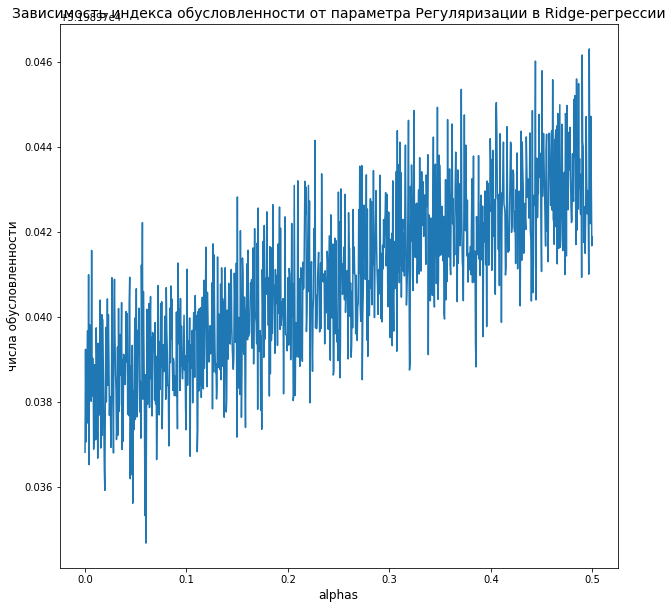

In [269]:
cond_numbres = list()
for i in ridge_grid:
    cond_numbres.append(cond_number_regression(matrix, i))
    
plt.figure(figsize=(10, 10))

plt.title("Зависимость индекса обусловленности от параметра " +\
         "Регуляризации в Ridge-регрессии", fontsize=14)
plt.xlabel("alphas", fontsize=12)
plt.ylabel("числа обусловленности", fontsize=12)

plt.plot(ridge_grid, cond_numbres)

plt.show()

Перейдем к более практической части. Разбейте исходную выборку на обучающую и тестовую (в этом поможет функция <a href="http://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.train_test_split.html">`train_test_split` </a> из библиотеки `sklearn`), обучив модель на одной части, постройте предсказание для другого куска для случаев линейной регрессии, Ridge и Lasso. Посчитайте среднеквадратичную ошибку (<a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html">`mean_squared_error` </a> также из библиотеки `sklearn`).

Исследуйте зависимость среднеквадратичной ошибки от параметра регуляризации для случаев Ridge и Lasso регрессии. Найдите оптимальное значение параметра для конкретного разбиения.

In [ ]:
<...>